# CIRIS - Coastal Inundation Risk estimation using InSAR and Sea level rise

In [10]:
import xarray as xr
import os
from inundation_risk import data_loader, preprocessing, interpolation, analysis, utils
from inundation_risk.data_loader import EGMS_zips_to_gdf, Prepare_DEM

Please provide the following information

In [11]:
output_dir = '/home/kleanthis/Projects/Thetida/test/'
CH_region_name = 'Mykonos_Castle'

bbox = {'lat_min':37.4,
        'lat_max':37.5,
        'lon_min':25.295,
        'lon_max':25.34}

### Data

SLR trends from Marine Copernicus (https://data.marine.copernicus.eu/product/OMI_CLIMATE_SL_GLOBAL_regional_trends/files?subdataset=omi_climate_sl_global_regional_trends_202406)

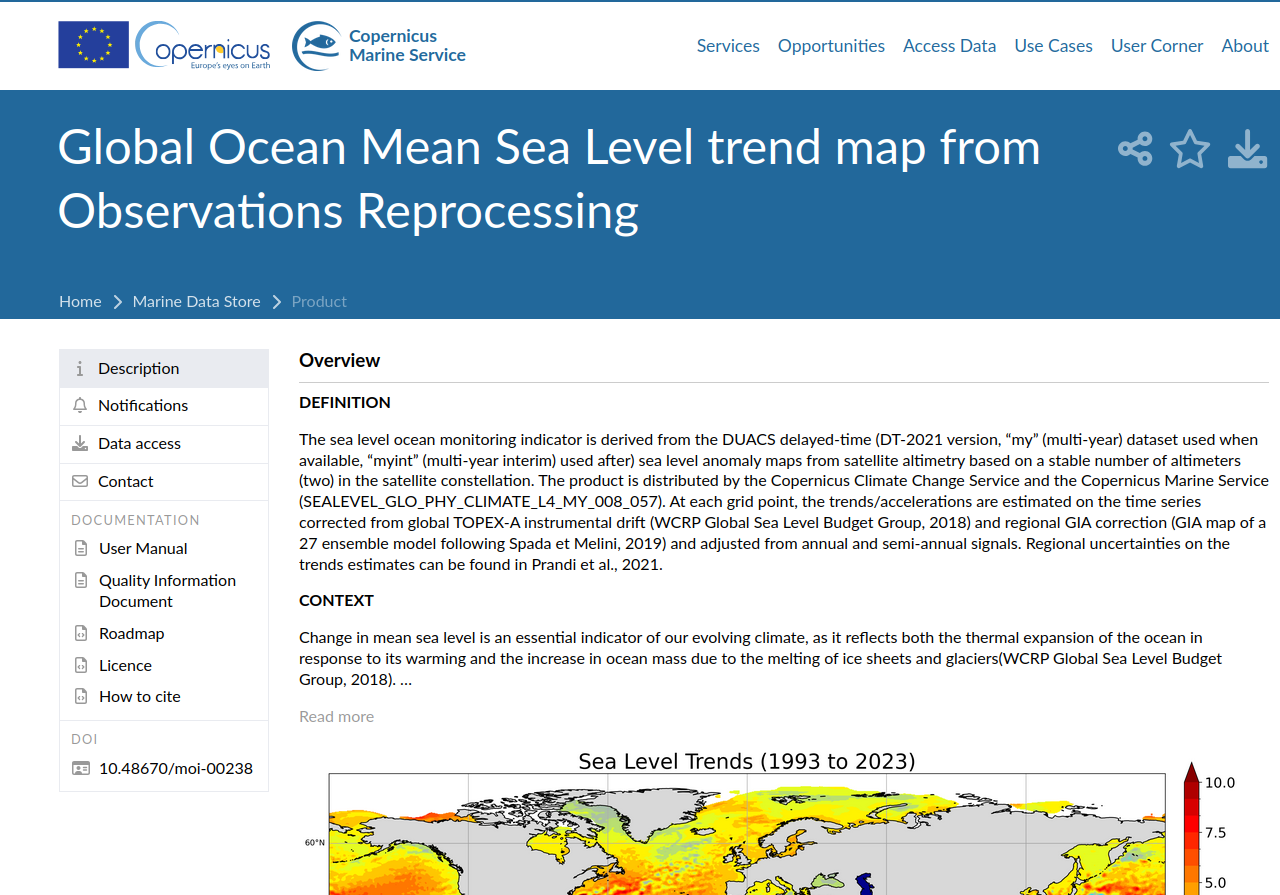

In [12]:
# filepath with sea level rise data
slr_path = 'ancillary_data/omi_climate_sl_global_regional_trends_19930101_P20240228.nc'

EEA coastline datasets (https://www.eea.europa.eu/en/datahub/datahubitem-view/af40333f-9e94-4926-a4f0-0a787f1d2b8f)

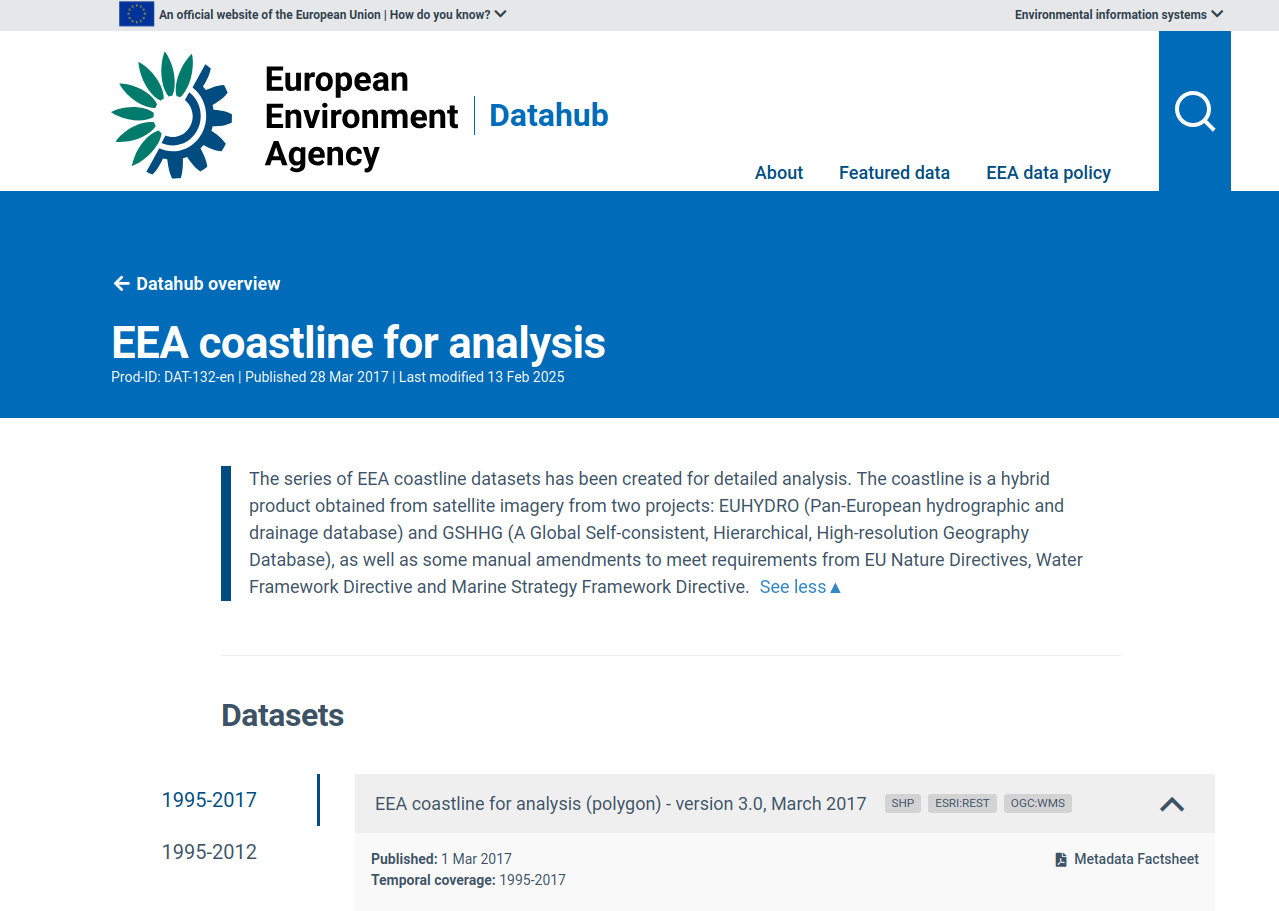

In [14]:
shoreline_path = 'ancillary_data/eea_v_3035_100_k_coastline-poly_1995-2017_p_v03_r00/EEA_Coastline_20170228.shp'

# You can also provide its own vector file (shapefile, geojson, etc) with polygons of your interest.

30m DEM from Copernicus (https://dataspace.copernicus.eu/explore-data/data-collections/copernicus-contributing-missions/collections-description/COP-DEM) https://doi.org/10.5270/ESA-c5d3d65 

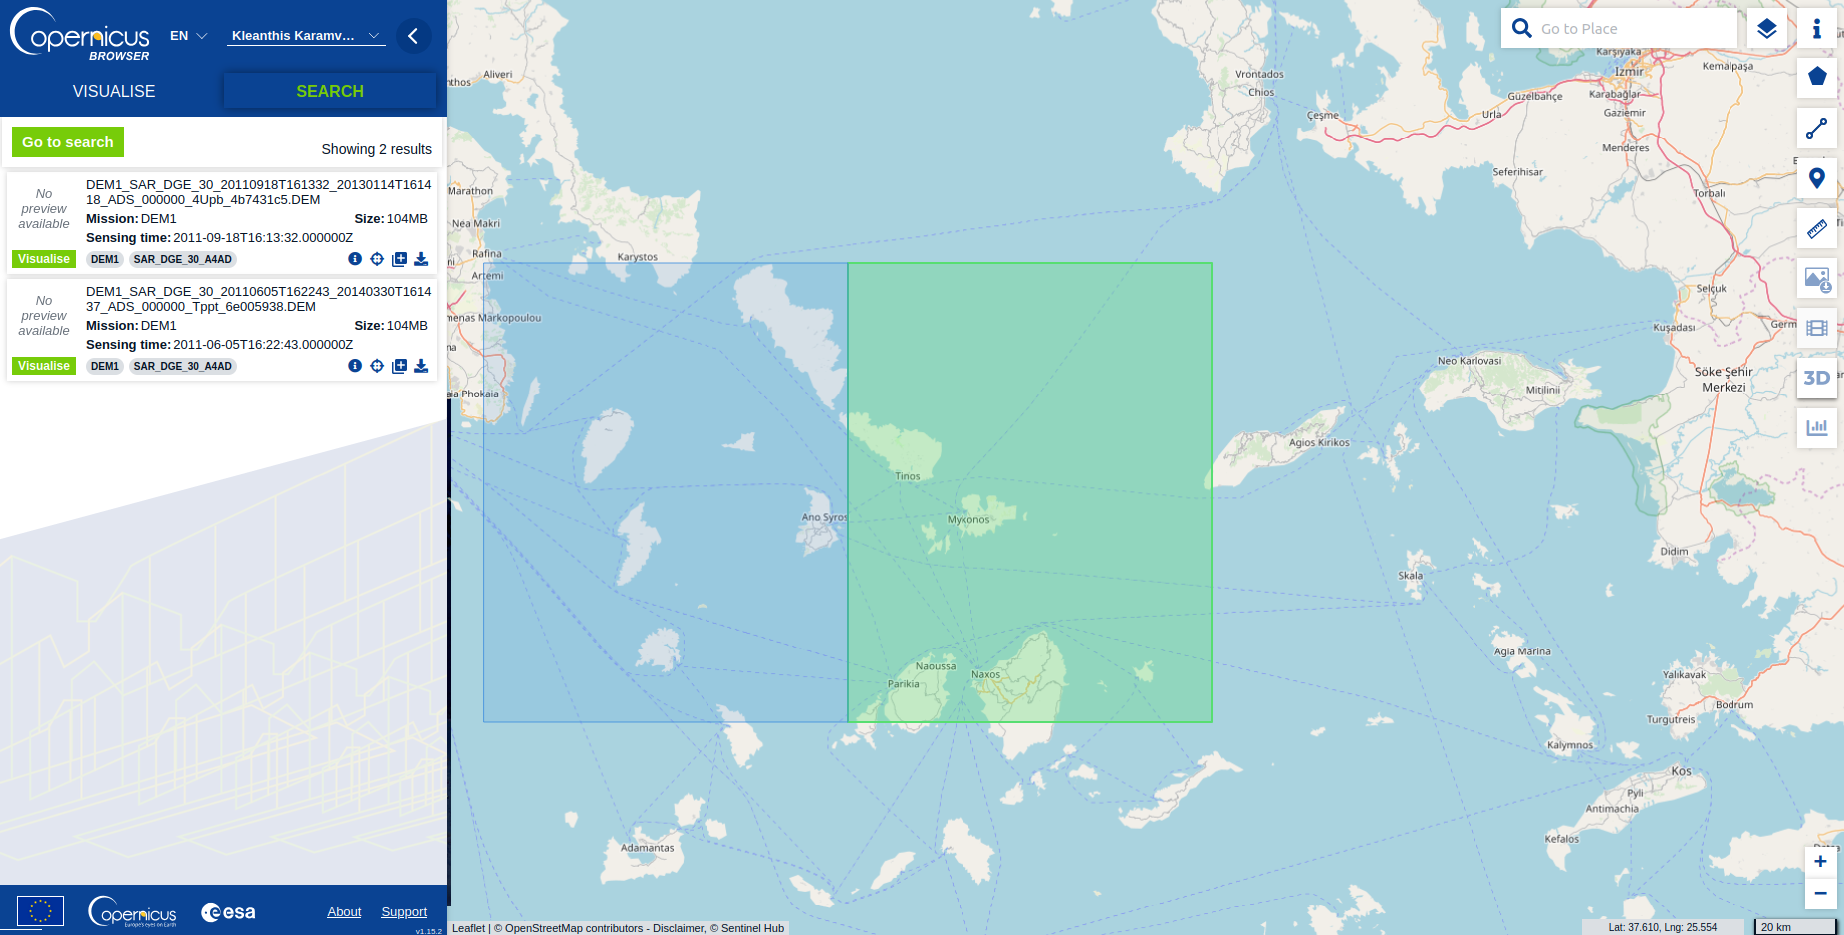

In [ ]:
# Please provide the zip DEM files for your area of interest.
DEM_zip_paths = ['/home/kleanthis/Projects/Thetida/test/DEM1_SAR_DGE_30_20110918T161332_20130114T161418_ADS_000000_4Upb_4b7431c5.DEM.zip',]
DEM_ref_year = 2011

DEM_filepath =  Prepare_DEM(DEM_zip_paths, output_dir, CH_region_name)

#### Land deformation (ORTHO-UP) data from EGMS (https://egms.land.copernicus.eu/)

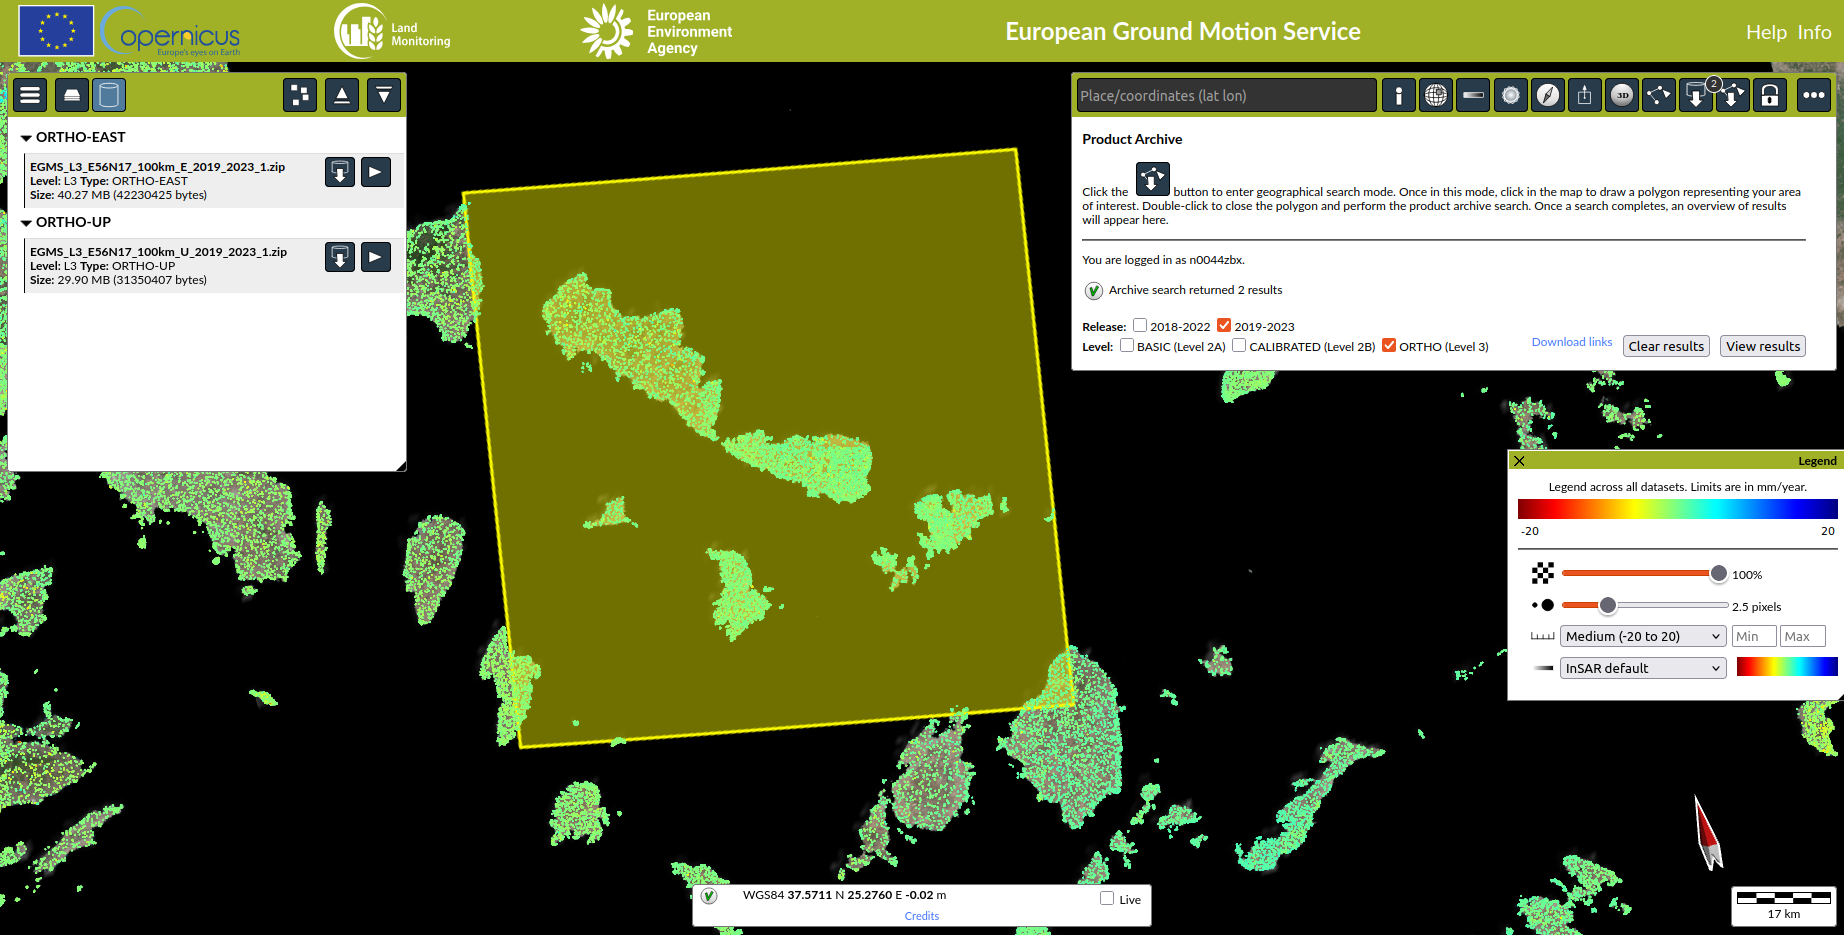

In [ ]:
# Please download data from EGMS Copernicus and provide the zip files
land_def_zip_paths = ['/home/kleanthis/Projects/Thetida/test/EGMS_L3_E56N17_100km_U_2019_2023_1.zip',]

land_def_path = EGMS_zips_to_gdf(land_def_zip_paths, bbox, output_dir)

Processing complete. GeoDataFrame ready.


### Coastal inundation risk calculation

In [17]:
# Load and process land deformations
land_def_gdf, bbox_gdf = data_loader.load_land_definition(land_def_path)

# calculate velocities from ground land deformations
land_def_gdf = analysis.calc_velocities(land_def_gdf)

# calculate the projected ground displacement from the reference DEM year to 10 years in the future
land_def_gdf = analysis.project_displacement_from_reference(land_def_gdf,
                                                   reference_year=DEM_ref_year,
                                                   future_offset=10)

# Get sea level rise trend
slr_value = data_loader.get_slr_value(slr_path, bbox_gdf.geometry[0].centroid)

# Compute RSLR and save to GeoJSON
rslr_gdf = analysis.compute_rslr(land_def_gdf, slr_value)

# Load DEM and interpolate RSLR
dem_xr = xr.open_dataset(DEM_filepath)
if dem_xr.rio.crs != bbox_gdf.crs:
    bbox_gdf = bbox_gdf.to_crs(dem_xr.rio.crs)

rslr_raster_masked = interpolation.interpolate_rslr(rslr_gdf, dem_xr, bbox_gdf)

# Clip RSLR raster using shoreline
rslr_clipped = preprocessing.clip_raster_to_shoreline(rslr_raster_masked, shoreline_path)

# Compute inundation risk
inundation_risk = analysis.compute_inundation_risk(rslr_clipped, dem_xr)
inundation_risk.name = "inundation_risk"

# Save results
inundation_risk.to_netcdf(os.path.join(output_dir, '_inundation_risk.nc'.format(CH_region_name)), format="NETCDF4")
print("Inundation risk saved to:", os.path.join(output_dir, '{}_inundation_risk.nc'.format(CH_region_name)))

utils.save_colormapped_tif(
    array=inundation_risk.values,
    transform=inundation_risk.rio.transform(),
    crs=inundation_risk.rio.crs,
    output_path=os.path.join(output_dir, '{}_inundation_risk.tif'.format(CH_region_name)))

Inundation risk saved to: /home/kleanthis/Projects/Thetida/test/Mykonos_Castle_inundation_risk.nc
✅ Color-mapped GeoTIFF saved to: /home/kleanthis/Projects/Thetida/test/Mykonos_Castle_inundation_risk.tif
